# import and Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
import warnings
warnings.filterwarnings('ignore')
#annots = loadmat('C:\\Users\\llinc\\GitHub\\retina_personal\\0406\\merge\\merge_0224_HMM_RL_G2.5_5min_Q100_6.5mW.mat')
%matplotlib inline

In [2]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [3]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
    Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
    Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Information[('test','SI')]=np.zeros(len(bitshift))
    Information[('test','UIx')]=np.zeros(len(bitshift))
    Information[('test','UIv')]=np.zeros(len(bitshift))
    Information[('test','CI')]=np.zeros(len(bitshift))
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
        Information[('test','UIx')][i] = np.nansum(pxvr*np.log2(pxvr*px/pxv/pxr))/dt
        Information[('test','UIv')][i] = np.nansum(pxvr*np.log2(pxvr*pv/pxv/pvr))/dt


        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

In [4]:
def Spike_Time_Generater(rdt, dt, Garmma=1):
    rdt = rdt*Garmma
    Spike_time = []
    
    counter = 0
    post_remainer_c = 0
    p = 1
    while True:
        the_random_number = 1-np.random.rand()
        while (the_random_number < p and counter < len(rdt)):
            p *= np.exp(-rdt[counter])
            counter += 1
        if counter >= len(rdt):
            break
        remainer_c = -np.log(p/the_random_number)/rdt[counter-1]
#         if remainer_c>=1 or remainer_c<=0:
#             print('shit!')
        Spike_time.append(dt*(counter-remainer_c))
        p = np.exp(-remainer_c*rdt[counter-1])
    return Spike_time[::Garmma]

# activation function
def NL(x,theta=0):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= x[i]-theta
    return(y)

# chose file

In [5]:
# exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0503'
# G = 4.5
# annots = loadmat(exp_folder+'\\merge\\'+'merge_0224_OUsmooth_RL_G'+str(G)+'_5min_Q100_6.5mW_1Hz.mat')

# exp_folder = 'D:\\GoogleDrive\\retina\\Exps\\2020\\0729'
# Fc = 8
# annots = loadmat(exp_folder+'\\merge\\'+'merge_0727_OUsmooth_Bright_UL_DR_G4.5_5min_Q100_6.5mW_'+str(Fc)+'Hz.mat')

exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408'
Fc_list = [2, 4,7,10]
annots_list = []
for Fc in Fc_list:
    annots_list.append(loadmat(exp_folder+'\\20200408_OU_cutoff='+str(Fc)+'_sort_unit2'))

In [6]:
dt = 0.01
sampling_rate = 20000
x_list, v_list, t_cor_list, T_list = [], [], [], []
for annots in annots_list:
    TimeStamps =np.round(np.squeeze(annots['TimeStamps']))
    TimeStamps = TimeStamps.astype(int)
    x = annots['a_data'][0, TimeStamps[0]*sampling_rate:TimeStamps[1]*sampling_rate+1]
    x = ndimage.gaussian_filter1d(x, sigma=int(sampling_rate*dt/2), mode='reflect') / dt
    x = x[::int(sampling_rate*dt)]
    x = x.astype(float)
    x = (x -np.mean(x))/np.std(x)
    T = np.arange(1,len(x)+1)*dt
    v = np.append(0,np.diff(x))/dt
    
    x_list.append(x.copy())
    v_list.append(v.copy())
    T_list.append(T.copy())
    x_cor = np.correlate(x, x, "same")
    x_cor = x_cor[:int((len(x_cor)+1)/2)+1]
    Taxis = np.flip(T[:len(x_cor)]-dt*3/2)
    t_cor_list.append(np.interp(0.5*max(x_cor),  x_cor, Taxis))

In [7]:
t_cor_list

[0.5241158203537964,
 0.4222846678783801,
 0.3954199641047879,
 0.38514798623074575]

# for $\beta$

In [8]:
# Lambdas =  np.arange(0.1,0.91,0.1)
Lambdas =  np.arange(0.3,0.5,0.3)
betas = (1-Lambdas)/Lambdas
alpha = 20. #1/sec
K = 23.
g = 40.
phi = 1.

In [9]:
##response
# Model one: simple estimation
window = [-1,1] # second
Information_list = [0]*len(annots_list)
ngd_Information_list = [0]*len(annots_list)
y_list = [0]*len(annots_list)
r_list = [0]*len(annots_list)
for i in range(len(annots_list)):
    x = x_list[i]
    v = v_list[i]
    xstate,edge = EqualState(x, 6)
    vstate,edge = EqualState(v, 6)
    Information_list[i] = [0]*len(Lambdas)
    ngd_Information_list[i] = [0]*len(Lambdas)
    y_list[i] = [0]*len(Lambdas)
    r_list[i] = [0]*len(Lambdas)
    for j in range(len(Lambdas)):
        Lambda = Lambdas[j]
        beta = betas[j]
        print(Fc_list[i], Lambda, beta)
        y=np.zeros(len(T_list[i]))
        z=np.zeros(len(T_list[i]))
        for k in range(len(T_list[i])-1):
            dy=dt*(-alpha*y[k]+K*(x[k]-phi*z[k]))
            dz=dt*(-beta*z[k]+g*y[k])
            y[k+1]=y[k]+dy
            z[k+1]=z[k]+dz
        y_list[i][j] = y.copy()
        r = NL(np.mean(y)-y, 0)
        ratio = sum(r)/T_list[i][-1]/12
#         ratio = sum(r)/585
        FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
        rstate, _ = np.histogram(FakeSpike, np.append(0,T_list[i]))
        rstate = rstate.astype(int)

        #calculate information
        timeshift, ngd_Information_list[i][j] = PIfunc(rstate, xstate, vstate, dt, window)
        
        r1 = (1-Lambda)*x+Lambda*v
        r_list[i][j] = r1.copy()
        r = NL(np.mean(r1)-r1, 0)
#         ratio = sum(r)/T_list[i][-1]/12
        ratio = sum(r)/585
        FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
        rstate, _ = np.histogram(FakeSpike, np.append(0,T_list[i]))
        rstate = rstate.astype(int)
        #calculate information
        timeshift, Information_list[i][j] = PIfunc(rstate, xstate, vstate, dt, window)

2 0.3 2.3333333333333335
4 0.3 2.3333333333333335
7 0.3 2.3333333333333335
10 0.3 2.3333333333333335


In [10]:
585/T_list[i][-1]

1.9564563058091704

# For Paper 

Fc= 10


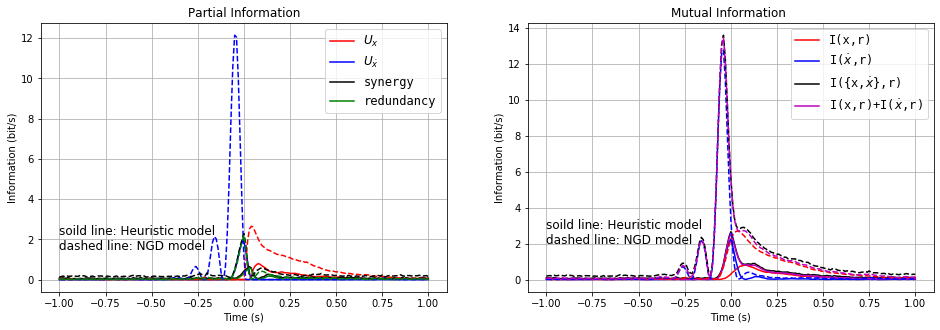

In [11]:
i = 3
print('Fc=', Fc_list[i])
for j in range(len(Lambdas)):
    fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2) 
    ax2.plot(timeshift,Information_list[i][j][('Beer','UIx')], 'r-')
    ax2.plot(timeshift,Information_list[i][j][('Beer','UIv')], 'b-')
    ax2.plot(timeshift,Information_list[i][j][('Beer','Syn')], 'k-')
    ax2.plot(timeshift,Information_list[i][j][('Beer','Red')], 'g-')
    ax2.plot(timeshift,ngd_Information_list[i][j][('Beer','UIx')], 'r--')
    ax2.plot(timeshift,ngd_Information_list[i][j][('Beer','UIv')], 'b--')
    ax2.plot(timeshift,ngd_Information_list[i][j][('Beer','Syn')], 'k--')
    ax2.plot(timeshift,ngd_Information_list[i][j][('Beer','Red')], 'g--')
    ax2.set_title('Partial Information')#+r'$t_{corr}$='+str(t_cor_list[i]))
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Information (bit/s)')
    ax2.legend( (r'$U_x$', r'$U_{\dotx}$', 'synergy', 'redundancy'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.grid()

    #plot MIs
    ax3.plot(timeshift,Information_list[i][j][('Beer','UIx')]+Information_list[i][j][('Beer','Red')], 'r-')
    ax3.plot(timeshift,Information_list[i][j][('Beer','UIv')]+Information_list[i][j][('Beer','Red')], 'b-')
    ax3.plot(timeshift,Information_list[i][j][('Beer','UIx')]+Information_list[i][j][('Beer','Red')]
             +Information_list[i][j][('Beer','UIv')]+Information_list[i][j][('Beer','Syn')], 'k-')
    ax3.plot(timeshift,Information_list[i][j][('Beer','UIx')]+2*Information_list[i][j][('Beer','Red')]
             +Information_list[i][j][('Beer','UIv')], 'm-')
    ax3.plot(timeshift,ngd_Information_list[i][j][('Beer','UIx')]+ngd_Information_list[i][j][('Beer','Red')], 'r--')
    ax3.plot(timeshift,ngd_Information_list[i][j][('Beer','UIv')]+ngd_Information_list[i][j][('Beer','Red')], 'b--')
    ax3.plot(timeshift,ngd_Information_list[i][j][('Beer','UIx')]+ngd_Information_list[i][j][('Beer','Red')]
             +ngd_Information_list[i][j][('Beer','UIv')]+ngd_Information_list[i][j][('Beer','Syn')], 'k--')
    ax3.plot(timeshift,ngd_Information_list[i][j][('Beer','UIx')]+2*ngd_Information_list[i][j][('Beer','Red')]
             +ngd_Information_list[i][j][('Beer','UIv')], 'm--')
    ax3.set_title('Mutual Information ')#+r'$t_{corr}$='+str(t_cor_list[i]))
    ax3.set_xlabel('Time (s)')
    ax3.set_ylabel('Information (bit/s)')
    ax3.grid()
    ax3.legend( ('I(x,r)', r'I($\dotx$,r)', r'I({x,$\dotx$},r)', r'I(x,r)+I($\dotx$,r)'), loc='best', prop={'size': 'large', 'family': 'monospace'})
    ax2.text(-1, 1.5,'soild line: Heuristic model \ndashed line: NGD model', fontsize = 12)
    ax3.text(-1, 2,'soild line: Heuristic model \ndashed line: NGD model', fontsize = 12)
    fig.set_size_inches(16, 4*(np.sqrt(5)-1))

In [12]:
# fig.savefig('D:\\GoogleDrive\\retina\\PID_paper\\HeuristicVSNGD_TLPID.jpeg')

In [13]:
# import pandas as pd
# Information_list[0][j][('timeshift','timeshift')] = timeshift
# Information_list[0][j][('MI','I(x,r)')] = Information_list[0][j][('Beer','UIx')]+Information_list[0][j][('Beer','Red')]
# Information_list[0][j][('MI',r'I($\dotx$,r)')] = Information_list[0][j][('Beer','UIv')]+Information_list[0][j][('Beer','Red')]
# Information_list[0][j][('MI',r'I({x,$\dotx$},r)')] = Information_list[0][j][('Beer','UIx')]+Information_list[0][j][('Beer','Red')]+Information_list[0][j][('Beer','UIv')]+Information_list[0][j][('Beer','Syn')]
# Information_list[0][j][('MI',r'I(x,r)+I($\dotx$,r)')] = Information_list[0][j][('Beer','UIx')]+2*Information_list[0][j][('Beer','Red')]+Information_list[0][j][('Beer','UIv')]
# data_df = pd.DataFrame(Information_list[i][j])

 
# # create and writer pd.DataFrame to excel
# name  = 'Piv'
# writer = pd.ExcelWriter('D:\\GoogleDrive\\retina\\PID_paper\\For Origin Plot\\'+name+'.xlsx')
# data_df.to_excel(writer,'page_1',float_format='%.5f') # float_format 控制精度

# # ngd_Information_list[0][j][('timeshift','timeshift')] = timeshift
# ngd_Information_list[0][j][('MI','I(x,r)')] = ngd_Information_list[0][j][('Beer','UIx')]+ngd_Information_list[0][j][('Beer','Red')]
# ngd_Information_list[0][j][('MI',r'I($\dotx$,r)')] = ngd_Information_list[0][j][('Beer','UIv')]+ngd_Information_list[0][j][('Beer','Red')]
# ngd_Information_list[0][j][('MI',r'I({x,$\dotx$},r)')] = ngd_Information_list[0][j][('Beer','UIx')]+ngd_Information_list[0][j][('Beer','Red')]+ngd_Information_list[0][j][('Beer','UIv')]+ngd_Information_list[0][j][('Beer','Syn')]
# ngd_Information_list[0][j][('MI',r'I(x,r)+I($\dotx$,r)')] = ngd_Information_list[0][j][('Beer','UIx')]+2*ngd_Information_list[0][j][('Beer','Red')]+ngd_Information_list[0][j][('Beer','UIv')]
# data_df = pd.DataFrame(ngd_Information_list[i][j])

 
# # create and writer pd.DataFrame to excel
# data_df.to_excel(writer,'page_2',float_format='%.5f') # float_format 控制精度
# writer.save()